Simulated Annealing Optimization
Problems: QAP and Six-Hump Camelback Function
Schedules: Geometric, Linear, Logarithmic
Criteria: Max Iterations, No Improvement, Temperature Threshold
Runs per configuration: 5
Total runs: 3 × 3 × 5 × 2 = 90


INITIAL RANDOM CONFIGURATIONS

QAP - 5 Random Initial Configurations:
------------------------------------------------------------------------------------------
Config | Department Assignment (0-14)                              | Total Cost
------------------------------------------------------------------------------------------
  1    |  9 11  0 13  5  8  2  1 14  4  7 10 12  3  6 |     1178
  2    | 10 12  0  8  9  6 11  3 13  1  4  5  2 14  7 |     1132
  3    |  1 12  4 10 13  7  6  3  2  0  8 14  5  9 11 |     1148
  4    |  2  7 13  0 11 10  5  9 12  3  1 14  8  4  6 |     1158
  5    | 10  8  4  9 14 13  0  5  2  7  6 12 11  3  1 |     1172

DEPARTMENT COST ANALYSIS FOR INITIAL CONFIGURATIONS 1 & 2

Configuration 1:
Solution: [9, 11, 0, 1

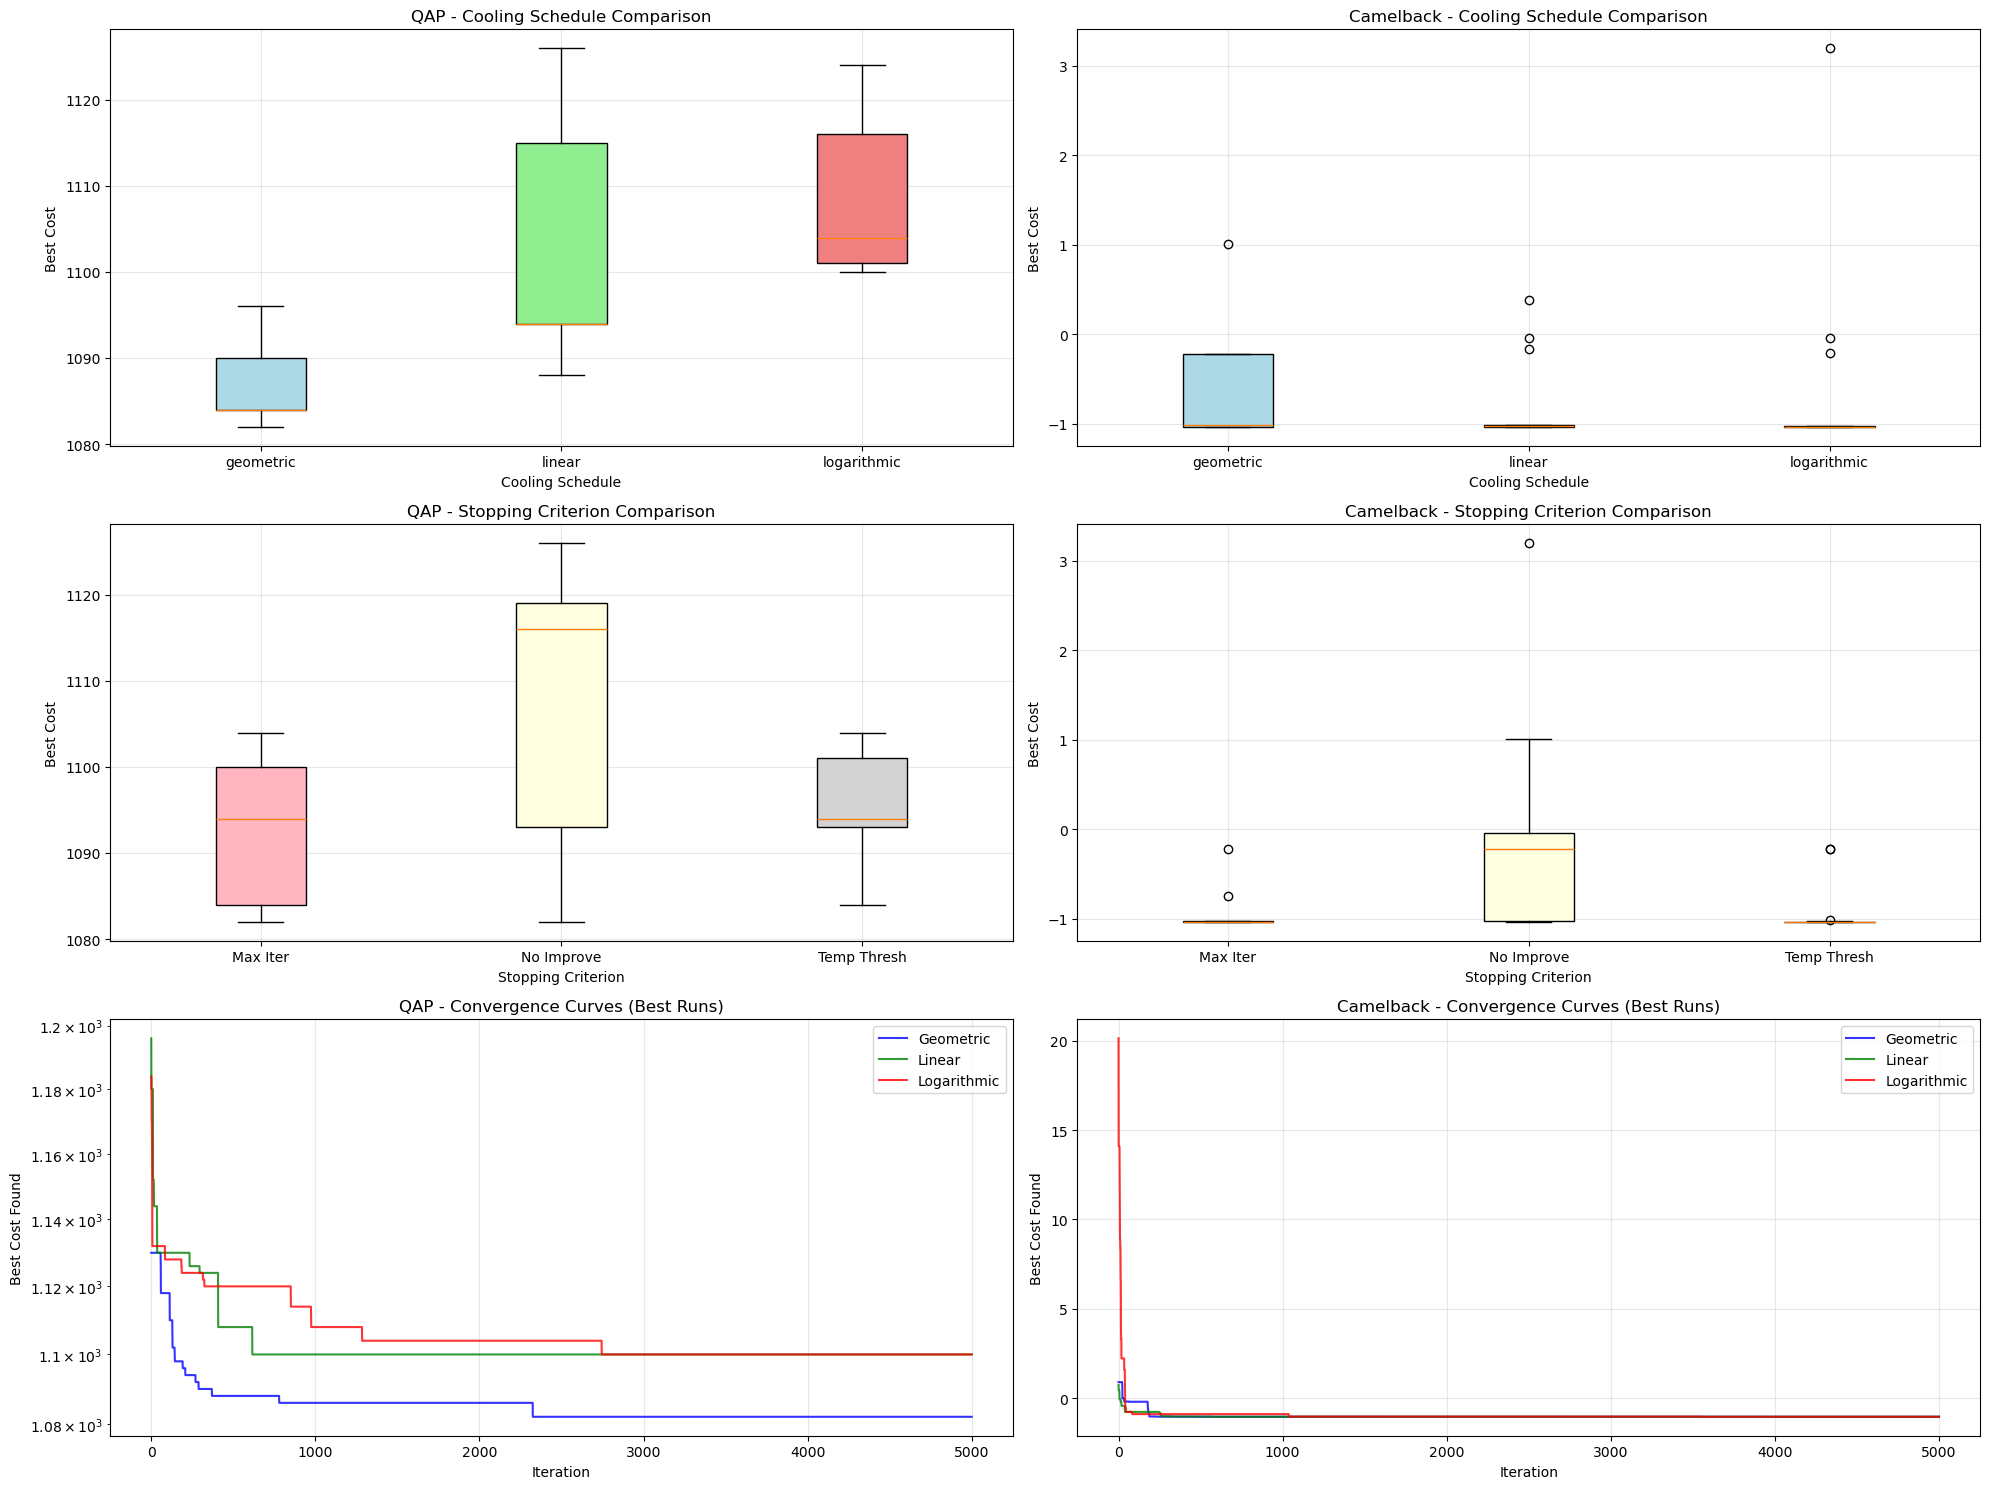

Visualizations saved as 'sa_analysis_plots.png'

Results saved to 'sa_results.csv'
Detailed appendix saved to 'Appendix Table Report.csv'

Analysis complete!

Files generated:
- sa_results.csv: Summary results table
- Appendix Table Report.csv: Complete run details for appendix
- sa_analysis_plots.png: Visualization plots

BEST SOLUTIONS FOUND

QAP Problem:
  Best Cost: 1082.000000
  Best Configuration: geometric cooling, max_iter stopping
  Solution: [12, 4, 0, 8, 3]...
  Iterations: 10000

Camelback Problem:
  Best Cost: -1.031617
  Best Configuration: linear cooling, max_iter stopping
  Solution: (-0.0913, 0.7134)
  Iterations: 10000


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy
from math import exp, log
from typing import List, Tuple, Callable, Dict, Any
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

class SimulatedAnnealing:
    """
    Simulated Annealing implementation for optimization problems.
    """
    
    def __init__(self, problem_name: str):
        self.problem_name = problem_name
        self.results = []
    
    def simulated_annealing(self, 
                          initial_solution_func: Callable,
                          objective_func: Callable,
                          neighbor_func: Callable,
                          cooling_schedule: str = 'geometric',
                          stopping_criterion: str = 'max_iter',
                          T0: float = 1000.0,
                          alpha: float = 0.95,
                          beta: float = 0.01,
                          max_iter: int = 10000,
                          no_improve_limit: int = 200,
                          temp_threshold: float = 1e-8,
                          **kwargs) -> Dict[str, Any]:
        """
        Main Simulated Annealing algorithm.
        
        Args:
            initial_solution_func: Function to generate initial solution
            objective_func: Function to evaluate solution quality
            neighbor_func: Function to generate neighbor solutions
            cooling_schedule: 'geometric', 'linear', or 'logarithmic'
            stopping_criterion: 'max_iter', 'no_improve', or 'temp_threshold'
            T0: Initial temperature
            alpha: Cooling rate for geometric schedule
            beta: Cooling parameter for linear schedule
            max_iter: Maximum iterations
            no_improve_limit: Max iterations without improvement
            temp_threshold: Temperature threshold for stopping
            
        Returns:
            Dictionary with results
        """
        
        # Initialize
        current_solution = initial_solution_func()
        current_cost = objective_func(current_solution)
        initial_solution = copy.deepcopy(current_solution)  # Store initial solution
        initial_cost = current_cost  # Store initial cost
        
        best_solution = copy.deepcopy(current_solution)
        best_cost = current_cost
        
        T = T0
        iteration = 0
        no_improve_count = 0
        
        # Track convergence
        cost_history = [current_cost]
        temp_history = [T]
        
        while True:
            iteration += 1
            
            # Generate neighbor solution
            neighbor_solution = neighbor_func(current_solution)
            neighbor_cost = objective_func(neighbor_solution)
            
            # Calculate cost difference
            delta = neighbor_cost - current_cost
            
            # Accept or reject the neighbor
            if delta < 0 or (T > 0 and random.random() < exp(-delta / T)):
                current_solution = neighbor_solution
                current_cost = neighbor_cost
                
                # Update best solution if improved
                if current_cost < best_cost:
                    best_solution = copy.deepcopy(current_solution)
                    best_cost = current_cost
                    no_improve_count = 0
                else:
                    no_improve_count += 1
            else:
                no_improve_count += 1
            
            # Record history
            cost_history.append(best_cost)
            temp_history.append(T)
            
            # Update temperature based on cooling schedule
            if cooling_schedule == 'geometric':
                T = T * alpha
            elif cooling_schedule == 'linear':
                T = T0 / (1 + beta * iteration)
            elif cooling_schedule == 'logarithmic':
                T = T0 / log(iteration + 2)
            
            # Check stopping criteria
            stop = False
            if stopping_criterion == 'max_iter' and iteration >= max_iter:
                stop = True
            elif stopping_criterion == 'no_improve' and no_improve_count >= no_improve_limit:
                stop = True
            elif stopping_criterion == 'temp_threshold' and T < temp_threshold:
                stop = True
            elif iteration >= max_iter:  # Safety net
                stop = True
                
            if stop:
                break
        
        return {
            'initial_solution': initial_solution,
            'initial_cost': initial_cost,
            'best_solution': best_solution,
            'best_cost': best_cost,
            'iterations': iteration,
            'cost_history': cost_history,
            'temp_history': temp_history,
            'cooling_schedule': cooling_schedule,
            'stopping_criterion': stopping_criterion,
            'T0': T0,
            'alpha': alpha,
            'beta': beta
        }

class QAProblem:
    """
    Quadratic Assignment Problem implementation.
    """
    
    def __init__(self):
        # Initialize flow and distance matrices (15x15)
        # Flow matrix (lower triangle) - departments interaction flows
        self.flow = np.array([
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [2, 1, 2, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [3, 2, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [4, 3, 2, 1, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 2, 3, 4, 1, 2, 3, 4, 0, 0, 0, 0, 0, 0, 0],
            [2, 1, 2, 3, 2, 1, 2, 3, 1, 0, 0, 0, 0, 0, 0],
            [3, 2, 1, 2, 3, 2, 1, 2, 2, 1, 0, 0, 0, 0, 0],
            [4, 3, 2, 1, 4, 3, 2, 1, 3, 2, 1, 0, 0, 0, 0],
            [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 0, 0, 0],
            [2, 1, 2, 3, 2, 1, 2, 3, 2, 1, 2, 3, 1, 0, 0],
            [3, 2, 1, 2, 3, 2, 1, 2, 3, 2, 1, 2, 2, 1, 0]
        ])
        
        # Make flow matrix symmetric
        self.flow = self.flow + self.flow.T
        
        # Distance matrix - Manhattan distance for 3x5 grid
        self.distance = self._calculate_distance_matrix()
    
    def _calculate_distance_matrix(self):
        """Calculate Manhattan distances for 3x5 grid layout."""
        distance = np.zeros((15, 15))
        
        # Convert location index to (row, col) coordinates
        def get_coords(loc):
            return loc // 5, loc % 5
        
        for i in range(15):
            for j in range(15):
                if i != j:
                    row1, col1 = get_coords(i)
                    row2, col2 = get_coords(j)
                    distance[i][j] = abs(row1 - row2) + abs(col1 - col2)
        
        return distance
    
    def generate_initial_solution(self):
        """Generate random permutation of departments to locations."""
        return list(np.random.permutation(15))
    
    def calculate_objective(self, solution):
        """Calculate total cost: sum of flow[i,j] * distance[loc(i), loc(j)]."""
        total_cost = 0
        for i in range(15):
            for j in range(15):
                if i != j:
                    loc_i = solution[i]
                    loc_j = solution[j]
                    total_cost += self.flow[i][j] * self.distance[loc_i][loc_j]
        return total_cost
    
    def cost_per_department(self, solution):
        """
        Compute the cost contribution of each department.
        
        Args:
            solution: List representing assignment of departments to locations
            
        Returns:
            tuple: (department_costs, total_cost) where department_costs is a list
                   of costs for each department and total_cost is the sum
        """
        department_costs = []
        total_cost = 0
        
        for i in range(15):
            dept_cost = 0
            loc_i = solution[i]
            
            for j in range(15):
                if i != j:
                    loc_j = solution[j]
                    cost_contribution = self.flow[i][j] * self.distance[loc_i][loc_j]
                    dept_cost += cost_contribution
                    total_cost += cost_contribution
            
            department_costs.append(dept_cost)
        
        # Since we double-count each pair, divide total by 2
        total_cost = total_cost // 2
        # But keep individual department costs as they represent outgoing flows
        
        return department_costs, total_cost
    
    def generate_neighbor(self, solution):
        """Generate neighbor by swapping two random departments."""
        neighbor = solution.copy()
        i, j = random.sample(range(15), 2)
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        return neighbor

class CamelbackProblem:
    """
    Six-Hump Camelback Function optimization problem.
    """
    
    def __init__(self):
        self.x_bounds = (-3, 3)
        self.y_bounds = (-2, 2)
    
    def generate_initial_solution(self):
        """Generate random point within bounds."""
        x = random.uniform(self.x_bounds[0], self.x_bounds[1])
        y = random.uniform(self.y_bounds[0], self.y_bounds[1])
        return (x, y)
    
    def calculate_objective(self, solution):
        """Calculate Six-Hump Camelback function value."""
        x, y = solution
        term1 = (4 - 2.1 * x**2 + x**4 / 3) * x**2
        term2 = x * y
        term3 = (-4 + 4 * y**2) * y**2
        return term1 + term2 + term3
    
    def generate_neighbor(self, solution):
        """Generate neighbor by adding small random perturbation."""
        x, y = solution
        
        # Add random perturbation (smaller range for better local search)
        dx = random.uniform(-0.2, 0.2)
        dy = random.uniform(-0.2, 0.2)
        
        new_x = np.clip(x + dx, self.x_bounds[0], self.x_bounds[1])
        new_y = np.clip(y + dy, self.y_bounds[0], self.y_bounds[1])
        
        return (new_x, new_y)

def print_initial_configurations():
    """Generate and print 5 random initial configurations for both problems with department costs."""
    
    print("=" * 100)
    print("INITIAL RANDOM CONFIGURATIONS")
    print("=" * 100)
    
    # QAP Initial Configurations
    print("\nQAP - 5 Random Initial Configurations:")
    print("-" * 90)
    print("Config | Department Assignment (0-14)                              | Total Cost")
    print("-" * 90)
    
    qap = QAProblem()
    initial_configs = []
    
    for i in range(5):
        solution = qap.generate_initial_solution()
        cost = qap.calculate_objective(solution)
        initial_configs.append((solution, cost))
        solution_str = ' '.join([f"{x:2d}" for x in solution])
        print(f"  {i+1}    | {solution_str} | {cost:8.0f}")
    
    # Print department costs for first two configurations
    print("\n" + "=" * 100)
    print("DEPARTMENT COST ANALYSIS FOR INITIAL CONFIGURATIONS 1 & 2")
    print("=" * 100)
    
    for config_num in [0, 1]:  # First two configurations
        solution, total_cost = initial_configs[config_num]
        dept_costs, _ = qap.cost_per_department(solution)
        
        print(f"\nConfiguration {config_num + 1}:")
        print(f"Solution: {solution}")
        print(f"Total Cost: {total_cost}")
        print("Department Costs:")
        print("-" * 70)
        print("Dept |  Location  |  Cost    | Dept |  Location  |  Cost")
        print("-" * 70)
        
        for i in range(0, 15, 2):
            if i + 1 < 15:
                loc1, cost1 = solution[i], int(dept_costs[i])
                loc2, cost2 = solution[i+1], int(dept_costs[i+1])
                print(f" {i:2d}  |     {loc1:2d}     | {cost1:7d}  | {i+1:2d}  |     {loc2:2d}     | {cost2:7d}")
            else:
                loc1, cost1 = solution[i], int(dept_costs[i])
                print(f" {i:2d}  |     {loc1:2d}     | {cost1:7d}  |    |           |        ")
        
        print("-" * 70)
        cost_list = [str(int(cost)) for cost in dept_costs]
        print(f"Department costs: {', '.join(cost_list)}")
    
    print("\n" + "-" * 90)
    
    # Camelback Initial Configurations
    print("\nCamelback Function - 5 Random Initial Configurations:")
    print("-" * 60)
    print("Config |      x      |      y      |   f(x,y)   ")
    print("-" * 60)
    
    camelback = CamelbackProblem()
    for i in range(5):
        solution = camelback.generate_initial_solution()
        cost = camelback.calculate_objective(solution)
        x, y = solution
        print(f"  {i+1}    | {x:10.6f} | {y:10.6f} | {cost:10.6f}")
    
    print("-" * 60)

def run_experiments():
    """Run all SA experiments for both problems."""
    
    # Print initial configurations first
    print_initial_configurations()
    
    # Initialize problems
    qap = QAProblem()
    camelback = CamelbackProblem()
    
    # Experimental parameters
    cooling_schedules = ['geometric', 'linear', 'logarithmic']
    stopping_criteria = ['max_iter', 'no_improve', 'temp_threshold']
    num_runs = 5
    
    # Parameters for SA
    sa_params = {
        'T0': 1000.0,
        'alpha': 0.95,
        'beta': 0.01,
        'max_iter': 10000,
        'no_improve_limit': 200,
        'temp_threshold': 1e-8
    }
    
    all_results = []
    appendix_results = []  # New list for detailed appendix data
    convergence_data = {}
    best_qap_result = None
    best_qap_cost = float('inf')
    
    print("\n\nStarting Simulated Annealing Experiments...")
    print("=" * 60)
    
    # Run experiments for both problems
    problems = [
        ('QAP', qap, qap.generate_initial_solution, qap.calculate_objective, qap.generate_neighbor),
        ('Camelback', camelback, camelback.generate_initial_solution, camelback.calculate_objective, camelback.generate_neighbor)
    ]
    
    for problem_name, problem_obj, init_func, obj_func, neighbor_func in problems:
        print(f"\n{problem_name} Problem:")
        print("-" * 30)
        
        convergence_data[problem_name] = {}
        
        for schedule in cooling_schedules:
            for criterion in stopping_criteria:
                print(f"  Running {schedule} cooling with {criterion} stopping...")
                
                convergence_data[problem_name][f"{schedule}_{criterion}"] = []
                
                for run in range(num_runs):
                    # Create SA instance
                    sa = SimulatedAnnealing(problem_name)
                    
                    # Run SA
                    result = sa.simulated_annealing(
                        initial_solution_func=init_func,
                        objective_func=obj_func,
                        neighbor_func=neighbor_func,
                        cooling_schedule=schedule,
                        stopping_criterion=criterion,
                        **sa_params
                    )
                    
                    # Track best QAP result for department cost analysis
                    if problem_name == 'QAP' and result['best_cost'] < best_qap_cost:
                        best_qap_cost = result['best_cost']
                        best_qap_result = result.copy()
                    
                    # Store summary results (original format)
                    run_data = {
                        'Problem': problem_name,
                        'Schedule': schedule,
                        'Criterion': criterion,
                        'Run': run + 1,
                        'Best_Cost': result['best_cost'],
                        'Iterations': result['iterations'],
                        'Best_Solution': str(result['best_solution'][:5]) + '...' if problem_name == 'QAP' 
                                       else f"({result['best_solution'][0]:.4f}, {result['best_solution'][1]:.4f})"
                    }
                    all_results.append(run_data)
                    
                    # Store detailed appendix results (new comprehensive format)
                    if problem_name == 'QAP':
                        # Format QAP solutions
                        initial_solution_str = ' '.join(map(str, result['initial_solution']))
                        final_solution_str = ' '.join(map(str, result['best_solution']))
                    else:
                        # Format Camelback solutions
                        x_init, y_init = result['initial_solution']
                        x_final, y_final = result['best_solution']
                        initial_solution_str = f"[{x_init:.6f}, {y_init:.6f}]"
                        final_solution_str = f"[{x_final:.6f}, {y_final:.6f}]"
                    
                    appendix_data = {
                        'Problem': problem_name,
                        'Run': run + 1,
                        'Cooling Schedule': schedule.capitalize(),
                        'Stopping Criterion': criterion.replace('_', ' ').title(),
                        'T0': result['T0'],
                        'Alpha': result['alpha'] if schedule == 'geometric' else 'N/A',
                        'Beta': result['beta'] if schedule == 'linear' else 'N/A',
                        'Initial Solution': initial_solution_str,
                        'Initial Cost': result['initial_cost'],
                        'Final Solution': final_solution_str,
                        'Final Cost': result['best_cost'],
                        'Iterations': result['iterations']
                    }
                    appendix_results.append(appendix_data)
                    
                    # Store convergence data
                    convergence_data[problem_name][f"{schedule}_{criterion}"].append(result['cost_history'])
                    
                    print(f"    Run {run+1}: Initial={result['initial_cost']:.2f}, Final={result['best_cost']:.6f}, Iterations={result['iterations']}")
    
    # Print department cost analysis for best QAP solution
    if best_qap_result:
        print_department_cost_analysis(qap, best_qap_result)
    
    # Create results DataFrames
    results_df = pd.DataFrame(all_results)
    appendix_df = pd.DataFrame(appendix_results)
    
    # Print complete appendix table
    print_complete_appendix_table(appendix_df)
    
    # Print summary statistics
    print("\n" + "=" * 60)
    print("SUMMARY STATISTICS")
    print("=" * 60)
    
    for problem in ['QAP', 'Camelback']:
        print(f"\n{problem} Problem Summary:")
        problem_data = results_df[results_df['Problem'] == problem]
        
        summary = problem_data.groupby(['Schedule', 'Criterion'])['Best_Cost'].agg(['mean', 'std', 'min', 'max']).round(6)
        print(summary)
    
    # Create visualizations
    create_visualizations(results_df, convergence_data)
    
    # Save results
    results_df.to_csv('sa_results.csv', index=False)
    appendix_df.to_csv('Appendix Table Report.csv', index=False)
    
    print(f"\nResults saved to 'sa_results.csv'")
    print(f"Detailed appendix saved to 'Appendix Table Report.csv'")
    
    return results_df, convergence_data

def print_complete_appendix_table(appendix_df):
    """Print the complete appendix table in a formatted way."""
    
    print("\n" + "=" * 120)
    print("COMPLETE APPENDIX TABLE - ALL EXPERIMENTAL RUNS")
    print("=" * 120)
    
    for problem in ['QAP', 'Camelback']:
        problem_data = appendix_df[appendix_df['Problem'] == problem]
        
        print(f"\n{problem} PROBLEM RESULTS:")
        print("-" * 120)
        
        if problem == 'QAP':
            print("Run | Schedule   | Criterion    | T0   | Alpha | Initial Cost | Final Cost | Iterations | Initial Solution (first 5)      | Final Solution (first 5)")
            print("-" * 120)
            
            for _, row in problem_data.iterrows():
                initial_short = ' '.join(row['Initial Solution'].split()[:5]) + '...'
                final_short = ' '.join(row['Final Solution'].split()[:5]) + '...'
                alpha_str = f"{row['Alpha']:.2f}" if row['Alpha'] != 'N/A' else 'N/A'
                
                print(f"{row['Run']:3d} | {row['Cooling Schedule']:10s} | {row['Stopping Criterion']:12s} | {row['T0']:4.0f} | {alpha_str:5s} | {row['Initial Cost']:12.0f} | {row['Final Cost']:10.0f} | {row['Iterations']:10d} | {initial_short:32s} | {final_short}")
        
        else:  # Camelback
            print("Run | Schedule   | Criterion    | T0   | Alpha | Initial Cost   | Final Cost     | Iterations | Initial Point           | Final Point")
            print("-" * 120)
            
            for _, row in problem_data.iterrows():
                alpha_str = f"{row['Alpha']:.2f}" if row['Alpha'] != 'N/A' else 'N/A'
                
                print(f"{row['Run']:3d} | {row['Cooling Schedule']:10s} | {row['Stopping Criterion']:12s} | {row['T0']:4.0f} | {alpha_str:5s} | {row['Initial Cost']:14.6f} | {row['Final Cost']:14.6f} | {row['Iterations']:10d} | {row['Initial Solution']:23s} | {row['Final Solution']}")
        
        print("-" * 120)

def print_department_cost_analysis(qap, best_result):
    """Print detailed cost analysis for the best QAP solution found."""
    
    best_solution = best_result['best_solution']
    dept_costs, total_cost = qap.cost_per_department(best_solution)
    
    print("\n" + "=" * 80)
    print("BEST QAP SOLUTION - DEPARTMENT COST ANALYSIS")
    print("=" * 80)
    print(f"Best Solution Found: {best_solution}")
    print(f"Total Cost: {best_result['best_cost']:.0f}")
    print(f"Configuration: {best_result['cooling_schedule']} cooling, {best_result['stopping_criterion']} stopping")
    print(f"Iterations: {best_result['iterations']}")
    
    print("\nCost Contribution by Department:")
    print("-" * 50)
    print("Dept |  Location  |  Cost Contribution")
    print("-" * 50)
    
    for i in range(15):
        location = best_solution[i]
        cost = dept_costs[i]
        print(f" {i:2d}  |     {location:2d}     |      {cost:8.0f}")
    
    print("-" * 50)
    print(f"Total Cost: {sum(dept_costs)//2:8.0f}")  # Divide by 2 to avoid double counting
    
    # Print department costs in a single row for easy copying
    print("\nDepartment Costs (for report):")
    cost_list = [str(int(cost)) for cost in dept_costs]
    print("Department costs: " + ", ".join(cost_list))
    
    print("=" * 80)

def create_visualizations(results_df, convergence_data):
    """Create plots for analysis."""
    
    plt.style.use('default')
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Boxplots comparing cooling schedules for each problem
    for i, problem in enumerate(['QAP', 'Camelback']):
        plt.subplot(3, 2, i + 1)
        problem_data = results_df[results_df['Problem'] == problem]
        
        # Boxplot by schedule
        schedules = ['geometric', 'linear', 'logarithmic']
        data_by_schedule = [problem_data[problem_data['Schedule'] == schedule]['Best_Cost'] 
                           for schedule in schedules]
        
        bp = plt.boxplot(data_by_schedule, labels=schedules, patch_artist=True)
        colors = ['lightblue', 'lightgreen', 'lightcoral']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        plt.title(f'{problem} - Cooling Schedule Comparison')
        plt.xlabel('Cooling Schedule')
        plt.ylabel('Best Cost')
        plt.grid(True, alpha=0.3)
    
    # 2. Boxplots comparing stopping criteria
    for i, problem in enumerate(['QAP', 'Camelback']):
        plt.subplot(3, 2, i + 3)
        problem_data = results_df[results_df['Problem'] == problem]
        
        criteria = ['max_iter', 'no_improve', 'temp_threshold']
        data_by_criteria = [problem_data[problem_data['Criterion'] == criterion]['Best_Cost'] 
                           for criterion in criteria]
        
        bp = plt.boxplot(data_by_criteria, labels=['Max Iter', 'No Improve', 'Temp Thresh'], patch_artist=True)
        colors = ['lightpink', 'lightyellow', 'lightgray']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        plt.title(f'{problem} - Stopping Criterion Comparison')
        plt.xlabel('Stopping Criterion')
        plt.ylabel('Best Cost')
        plt.grid(True, alpha=0.3)
    
    # 3. Convergence curves (best runs for each schedule)
    for i, problem in enumerate(['QAP', 'Camelback']):
        plt.subplot(3, 2, i + 5)
        
        colors = ['blue', 'green', 'red']
        for j, schedule in enumerate(['geometric', 'linear', 'logarithmic']):
            # Get best run for this schedule (lowest final cost)
            key = f"{schedule}_max_iter"  # Use max_iter for full convergence curve
            if key in convergence_data[problem]:
                histories = convergence_data[problem][key]
                best_history = min(histories, key=lambda x: x[-1])  # Best final cost
                
                # Truncate to reasonable length for plotting
                max_len = min(len(best_history), 5000)
                x_vals = range(max_len)
                y_vals = best_history[:max_len]
                
                plt.plot(x_vals, y_vals, color=colors[j], label=schedule.capitalize(), alpha=0.8)
        
        plt.title(f'{problem} - Convergence Curves (Best Runs)')
        plt.xlabel('Iteration')
        plt.ylabel('Best Cost Found')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.yscale('log' if problem == 'QAP' else 'linear')
    
    plt.tight_layout()
    plt.savefig('sa_analysis_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Visualizations saved as 'sa_analysis_plots.png'")

def main():
    """Main function to run the complete analysis."""
    
    print("Simulated Annealing Optimization")
    print("Problems: QAP and Six-Hump Camelback Function")
    print("Schedules: Geometric, Linear, Logarithmic")
    print("Criteria: Max Iterations, No Improvement, Temperature Threshold")
    print("Runs per configuration: 5")
    print("Total runs: 3 × 3 × 5 × 2 = 90")
    print("\n")
    
    # Run all experiments
    results_df, convergence_data = run_experiments()
    
    print("\nAnalysis complete!")
    print("\nFiles generated:")
    print("- sa_results.csv: Summary results table")
    print("- Appendix Table Report.csv: Complete run details for appendix")
    print("- sa_analysis_plots.png: Visualization plots")
    
    # Display final best solutions
    print("\n" + "=" * 60)
    print("BEST SOLUTIONS FOUND")
    print("=" * 60)
    
    for problem in ['QAP', 'Camelback']:
        problem_data = results_df[results_df['Problem'] == problem]
        best_row = problem_data.loc[problem_data['Best_Cost'].idxmin()]
        
        print(f"\n{problem} Problem:")
        print(f"  Best Cost: {best_row['Best_Cost']:.6f}")
        print(f"  Best Configuration: {best_row['Schedule']} cooling, {best_row['Criterion']} stopping")
        print(f"  Solution: {best_row['Best_Solution']}")
        print(f"  Iterations: {best_row['Iterations']}")

if __name__ == "__main__":
    main()